In [1]:
# # MNIST Data
# import numpy as np
# from tensorflow.examples.tutorials.mnist import input_data
# import impl.layer as l

# # Dataset preparation and pre-processing
# mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

# X_train, y_train = mnist.train.images, mnist.train.labels
# X_val, y_val = mnist.validation.images, mnist.validation.labels
# X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype, y_train.shape, y_val.shape, y_test.shape

In [2]:
import pandas as pd # to read CSV files (Comma Separated Values)

train_x = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/train.x.csv')
train_y = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/train.y.csv')
test_x = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/test.x.csv')
train_y.head()

,Id,class_label
0,1,International
1,2,Vocal
2,3,Latin
3,4,Blues
4,5,Vocal


In [3]:
import numpy as np

train_X = np.array(train_x)
train_Y = np.array(train_y[:]['class_label'])
test_X = np.array(test_x)

X_train_val = np.array(train_X[:, 1:-1], dtype=float)
X_test = np.array(test_X[:, 1:], dtype=float)

In [4]:
from collections import Counter

# # Count the freq of words in the text/collection of words
# word_counts = Counter(text)
# # Having counted the frequency of the words in collection, sort them from most to least/top to bottom/descendng
# sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
# # first enumerating for vocab to int
# vocab_to_int = {words: ii for ii, words in enumerate(sorted_vocab)}
# # into_to_vocab after enumerating through the sorted vocab
# int_to_vocab = {ii: words for words, ii in vocab_to_int.items()}

counted_labels = Counter(train_Y)
key_to_val = {key: val for val, key in enumerate(counted_labels)}
key_to_val['Country']

val_to_key = {val: key for val, key in enumerate(counted_labels)}
val_to_key[1]

# labels = []
# for val, key in enumerate(counted_labels):
#     print(val, key)
#     labels.append(val)
  
# labels = np.array(labels, dtype=int)
# labels.size, np.max(labels), labels

'Vocal'

In [5]:
# from impl.layer import onehot

# labels_onehot = onehot(labels)

# labels, labels_onehot, counted_labels.keys()
# key_to_vec = {key: vec for key, vec in zip(counted_labels.keys(), labels_onehot)}
# key_to_vec, key_to_vec['Vocal']

Y_train_vec = []
for each in train_y[:]['class_label']:
#     print(each, key_to_val[each])
    Y_train_vec.append(key_to_val[each])

Y_train_val = np.array(Y_train_vec)
Y_train_val.shape

(13000,)

In [6]:
# # Pre-processing: normalizing
# def normalize(X):
#     # max scale for images 255= 2**8= 8 bit grayscale for each channel
#     return (X - X.mean(axis=0)) #/ X.std(axis=0)
# X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

# Preprocessing: normalizing the data based on the training set
mean = X_train_val.mean(axis=0)
std = X_train_val.std(axis=0)

X_train_val, X_test = (X_train_val - mean)/ std, (X_test - mean)/ std

In [7]:
# Creating validation set: 10% or 1/10 of the training set or whatever dataset with labels/ annotation
valid_size = X_train_val.shape[0]//10
valid_size
X_val = X_train_val[-valid_size:]
Y_val = Y_train_val[-valid_size:]
X_train = X_train_val[: -valid_size]
Y_train = Y_train_val[: -valid_size]
X_train_val.shape, 
X_train.shape, X_val.shape, X_test.shape, Y_val.shape, Y_train.shape 
# X_train.dtype, X_val.dtype
# Y_train.dtype, Y_val

((11700, 26), (1300, 26), (10400, 26), (1300,), (11700,))

In [8]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.ys_prev = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        # Previous output layer
        self.ys_prev.append(0.0)

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        # Previous output layer
        ys_prev_L = []
        for _ in range(L):
            ys_prev_L.append(0.0)
        self.ys_prev.append(ys_prev_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        # Previous output layer
        self.ys_prev.append(0.0)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        dX = dout @ W.T # Backprop
#         dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        ys.append(y) # ys[0]
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches, ys_L = [], [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
            ys_L.append(y) # ys[1][layer]
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        ys.append(ys_L) # ys[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[2]

        return ys, caches # for backpropating the error

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches, ys):
        grads, ys_prev = self.grads, self.ys_prev # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy *= ys[1][layer] - ys_prev[1][layer] # temporal diff instead of differentiable function
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy *= ys[0] - ys_prev[0] # temporal diff instead of differentiable function
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        ys_logit, _ = self.train_forward(X, train=False)
        y_logit = ys_logit[2] # last layer
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            ys, caches = self.train_forward(X_mini, train=True)
            loss, dy = self.loss_function(ys[2], y_mini)
            _, grads = self.train_backward(dy, caches, ys) # ys[0], ys[1] and ys_prev are used for backprop
            self.ys_prev = ys # for next iteration or epoch learning dW and db
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

#         # Test the final model
#         y_pred, y_logit = nn.test(X_test)
#         loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
#         acc = np.mean(y_pred == y_test)
#         print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
#             acc.mean(), acc.std(), loss))

In [9]:
Y_train.shape, X_train.shape, X_val.shape, Y_val.shape

((11700,), (11700, 26), (1300, 26), (1300,))

In [10]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 100 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = Y_train.max() + 1 # number of classes in this classification problem
# num_output_units = Y_train.shape[1] # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, Y_train), val_set=(X_val, Y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-100 train loss: 2.5897 valid loss: 2.5683, valid accuracy: 0.0931
Iter-200 train loss: 2.5537 valid loss: 2.5631, valid accuracy: 0.0969
Iter-300 train loss: 2.5550 valid loss: 2.5577, valid accuracy: 0.1000
Iter-400 train loss: 2.6012 valid loss: 2.5526, valid accuracy: 0.1046
Iter-500 train loss: 2.5234 valid loss: 2.5474, valid accuracy: 0.1100
Iter-600 train loss: 2.5492 valid loss: 2.5424, valid accuracy: 0.1115
Iter-700 train loss: 2.4950 valid loss: 2.5373, valid accuracy: 0.1146
Iter-800 train loss: 2.5337 valid loss: 2.5324, valid accuracy: 0.1177
Iter-900 train loss: 2.5303 valid loss: 2.5275, valid accuracy: 0.1223
Iter-1000 train loss: 2.5531 valid loss: 2.5225, valid accuracy: 0.1262
Iter-1100 train loss: 2.5206 valid loss: 2.5177, valid accuracy: 0.1308
Iter-1200 train loss: 2.5923 valid loss: 2.5130, valid accuracy: 0.1331
Iter-1300 train loss: 2.5346 valid loss: 2.5082, valid accuracy: 0.1415
Iter-1400 train loss: 2.4967 valid loss: 2.5035, valid accuracy: 0.1446
I

Iter-11500 train loss: 2.1253 valid loss: 2.2069, valid accuracy: 0.2531
Iter-11600 train loss: 2.0155 valid loss: 2.2058, valid accuracy: 0.2562
Iter-11700 train loss: 2.1839 valid loss: 2.2046, valid accuracy: 0.2538
Iter-11800 train loss: 2.1695 valid loss: 2.2031, valid accuracy: 0.2538
Iter-11900 train loss: 2.2686 valid loss: 2.2018, valid accuracy: 0.2538
Iter-12000 train loss: 2.3379 valid loss: 2.2006, valid accuracy: 0.2577
Iter-12100 train loss: 2.1797 valid loss: 2.1994, valid accuracy: 0.2577
Iter-12200 train loss: 2.2479 valid loss: 2.1982, valid accuracy: 0.2562
Iter-12300 train loss: 2.2075 valid loss: 2.1970, valid accuracy: 0.2562
Iter-12400 train loss: 2.2111 valid loss: 2.1958, valid accuracy: 0.2554
Iter-12500 train loss: 2.1747 valid loss: 2.1947, valid accuracy: 0.2562
Iter-12600 train loss: 1.9998 valid loss: 2.1934, valid accuracy: 0.2562
Iter-12700 train loss: 2.0771 valid loss: 2.1922, valid accuracy: 0.2546
Iter-12800 train loss: 2.1354 valid loss: 2.1910, v

Iter-22800 train loss: 2.2123 valid loss: 2.1095, valid accuracy: 0.2969
Iter-22900 train loss: 2.1989 valid loss: 2.1090, valid accuracy: 0.2985
Iter-23000 train loss: 2.0893 valid loss: 2.1082, valid accuracy: 0.2992
Iter-23100 train loss: 1.9585 valid loss: 2.1074, valid accuracy: 0.3008
Iter-23200 train loss: 2.1065 valid loss: 2.1069, valid accuracy: 0.3038
Iter-23300 train loss: 2.2066 valid loss: 2.1065, valid accuracy: 0.3031
Iter-23400 train loss: 2.0239 valid loss: 2.1058, valid accuracy: 0.3031
Iter-23500 train loss: 2.1755 valid loss: 2.1055, valid accuracy: 0.3031
Iter-23600 train loss: 2.0116 valid loss: 2.1049, valid accuracy: 0.3008
Iter-23700 train loss: 1.9082 valid loss: 2.1046, valid accuracy: 0.2992
Iter-23800 train loss: 2.1300 valid loss: 2.1040, valid accuracy: 0.3008
Iter-23900 train loss: 2.0557 valid loss: 2.1033, valid accuracy: 0.3054
Iter-24000 train loss: 1.9915 valid loss: 2.1027, valid accuracy: 0.3038
Iter-24100 train loss: 1.8546 valid loss: 2.1021, v

Iter-34100 train loss: 1.8828 valid loss: 2.0612, valid accuracy: 0.3200
Iter-34200 train loss: 1.9178 valid loss: 2.0611, valid accuracy: 0.3192
Iter-34300 train loss: 2.1090 valid loss: 2.0606, valid accuracy: 0.3208
Iter-34400 train loss: 2.0991 valid loss: 2.0602, valid accuracy: 0.3208
Iter-34500 train loss: 1.7571 valid loss: 2.0600, valid accuracy: 0.3223
Iter-34600 train loss: 1.8803 valid loss: 2.0597, valid accuracy: 0.3192
Iter-34700 train loss: 2.0300 valid loss: 2.0595, valid accuracy: 0.3208
Iter-34800 train loss: 1.9922 valid loss: 2.0592, valid accuracy: 0.3192
Iter-34900 train loss: 2.3007 valid loss: 2.0589, valid accuracy: 0.3185
Iter-35000 train loss: 2.0619 valid loss: 2.0585, valid accuracy: 0.3200
Iter-35100 train loss: 1.9501 valid loss: 2.0581, valid accuracy: 0.3192
Iter-35200 train loss: 2.0452 valid loss: 2.0578, valid accuracy: 0.3215
Iter-35300 train loss: 2.0881 valid loss: 2.0576, valid accuracy: 0.3200
Iter-35400 train loss: 2.2670 valid loss: 2.0574, v

Iter-45400 train loss: 1.9869 valid loss: 2.0369, valid accuracy: 0.3277
Iter-45500 train loss: 1.8522 valid loss: 2.0368, valid accuracy: 0.3254
Iter-45600 train loss: 2.1515 valid loss: 2.0367, valid accuracy: 0.3269
Iter-45700 train loss: 1.9967 valid loss: 2.0364, valid accuracy: 0.3277
Iter-45800 train loss: 2.0322 valid loss: 2.0361, valid accuracy: 0.3277
Iter-45900 train loss: 2.0782 valid loss: 2.0362, valid accuracy: 0.3285
Iter-46000 train loss: 2.0655 valid loss: 2.0359, valid accuracy: 0.3285
Iter-46100 train loss: 1.9845 valid loss: 2.0359, valid accuracy: 0.3277
Iter-46200 train loss: 2.0143 valid loss: 2.0362, valid accuracy: 0.3285
Iter-46300 train loss: 1.7571 valid loss: 2.0361, valid accuracy: 0.3292
Iter-46400 train loss: 1.9806 valid loss: 2.0361, valid accuracy: 0.3285
Iter-46500 train loss: 1.9609 valid loss: 2.0359, valid accuracy: 0.3277
Iter-46600 train loss: 1.9240 valid loss: 2.0357, valid accuracy: 0.3277
Iter-46700 train loss: 1.6956 valid loss: 2.0359, v

Iter-56700 train loss: 1.7650 valid loss: 2.0221, valid accuracy: 0.3346
Iter-56800 train loss: 1.9571 valid loss: 2.0218, valid accuracy: 0.3346
Iter-56900 train loss: 2.0383 valid loss: 2.0217, valid accuracy: 0.3346
Iter-57000 train loss: 1.9173 valid loss: 2.0215, valid accuracy: 0.3362
Iter-57100 train loss: 2.1130 valid loss: 2.0216, valid accuracy: 0.3354
Iter-57200 train loss: 1.9784 valid loss: 2.0215, valid accuracy: 0.3346
Iter-57300 train loss: 2.1093 valid loss: 2.0214, valid accuracy: 0.3346
Iter-57400 train loss: 1.8961 valid loss: 2.0213, valid accuracy: 0.3346
Iter-57500 train loss: 1.8306 valid loss: 2.0211, valid accuracy: 0.3338
Iter-57600 train loss: 2.0198 valid loss: 2.0212, valid accuracy: 0.3338
Iter-57700 train loss: 1.9476 valid loss: 2.0211, valid accuracy: 0.3338
Iter-57800 train loss: 1.9770 valid loss: 2.0213, valid accuracy: 0.3323
Iter-57900 train loss: 1.6934 valid loss: 2.0214, valid accuracy: 0.3346
Iter-58000 train loss: 2.1548 valid loss: 2.0213, v

Iter-68000 train loss: 2.0268 valid loss: 2.0129, valid accuracy: 0.3385
Iter-68100 train loss: 1.8299 valid loss: 2.0125, valid accuracy: 0.3408
Iter-68200 train loss: 1.9055 valid loss: 2.0125, valid accuracy: 0.3408
Iter-68300 train loss: 1.9774 valid loss: 2.0125, valid accuracy: 0.3392
Iter-68400 train loss: 2.0613 valid loss: 2.0122, valid accuracy: 0.3392
Iter-68500 train loss: 1.9266 valid loss: 2.0122, valid accuracy: 0.3400
Iter-68600 train loss: 2.1044 valid loss: 2.0120, valid accuracy: 0.3408
Iter-68700 train loss: 1.9038 valid loss: 2.0120, valid accuracy: 0.3400
Iter-68800 train loss: 2.2392 valid loss: 2.0119, valid accuracy: 0.3369
Iter-68900 train loss: 2.0981 valid loss: 2.0120, valid accuracy: 0.3377
Iter-69000 train loss: 1.8121 valid loss: 2.0119, valid accuracy: 0.3392
Iter-69100 train loss: 2.0279 valid loss: 2.0116, valid accuracy: 0.3385
Iter-69200 train loss: 1.6406 valid loss: 2.0116, valid accuracy: 0.3392
Iter-69300 train loss: 2.0755 valid loss: 2.0117, v

Iter-79300 train loss: 1.8793 valid loss: 2.0036, valid accuracy: 0.3477
Iter-79400 train loss: 1.7556 valid loss: 2.0031, valid accuracy: 0.3469
Iter-79500 train loss: 2.1988 valid loss: 2.0030, valid accuracy: 0.3469
Iter-79600 train loss: 1.9650 valid loss: 2.0031, valid accuracy: 0.3469
Iter-79700 train loss: 1.8963 valid loss: 2.0031, valid accuracy: 0.3469
Iter-79800 train loss: 1.9435 valid loss: 2.0031, valid accuracy: 0.3477
Iter-79900 train loss: 1.9230 valid loss: 2.0029, valid accuracy: 0.3469
Iter-80000 train loss: 1.8260 valid loss: 2.0029, valid accuracy: 0.3477
Iter-80100 train loss: 1.9495 valid loss: 2.0030, valid accuracy: 0.3462
Iter-80200 train loss: 1.7477 valid loss: 2.0030, valid accuracy: 0.3462
Iter-80300 train loss: 1.9556 valid loss: 2.0029, valid accuracy: 0.3438
Iter-80400 train loss: 2.0053 valid loss: 2.0029, valid accuracy: 0.3446
Iter-80500 train loss: 2.3430 valid loss: 2.0026, valid accuracy: 0.3477
Iter-80600 train loss: 2.0001 valid loss: 2.0025, v

Iter-90600 train loss: 1.9422 valid loss: 1.9974, valid accuracy: 0.3438
Iter-90700 train loss: 2.0892 valid loss: 1.9973, valid accuracy: 0.3415
Iter-90800 train loss: 1.9383 valid loss: 1.9972, valid accuracy: 0.3438
Iter-90900 train loss: 1.7170 valid loss: 1.9972, valid accuracy: 0.3454
Iter-91000 train loss: 1.9684 valid loss: 1.9972, valid accuracy: 0.3431
Iter-91100 train loss: 1.8422 valid loss: 1.9972, valid accuracy: 0.3454
Iter-91200 train loss: 1.9010 valid loss: 1.9972, valid accuracy: 0.3446
Iter-91300 train loss: 1.9168 valid loss: 1.9973, valid accuracy: 0.3423
Iter-91400 train loss: 1.7891 valid loss: 1.9974, valid accuracy: 0.3446
Iter-91500 train loss: 2.1152 valid loss: 1.9973, valid accuracy: 0.3400
Iter-91600 train loss: 1.9728 valid loss: 1.9972, valid accuracy: 0.3431
Iter-91700 train loss: 2.1179 valid loss: 1.9971, valid accuracy: 0.3423
Iter-91800 train loss: 1.9754 valid loss: 1.9968, valid accuracy: 0.3423
Iter-91900 train loss: 1.7734 valid loss: 1.9969, v

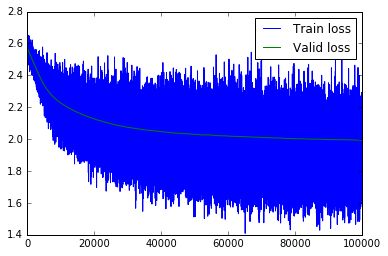

In [11]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

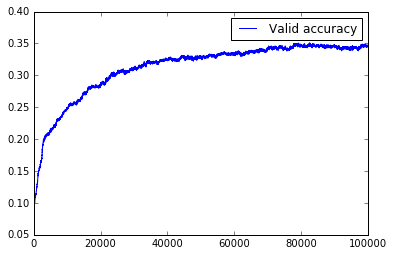

In [12]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()

In [124]:
# Test the final model
# y_pred, y_logit = nn.test(X_test)
# loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
# acc = np.mean(y_pred == y_test)
# print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
#     acc.mean(), acc.std(), loss))
# y_pred, y_logits = nn.test(X_test)
# mplot.imsave(y_pred)
# pd.DataFrame.to_csv(y_pred)
# y_pred.shape
# import numpy
# a = numpy.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
# numpy.savetxt("foo.csv", a, delimiter=",")
# np.savetxt(X=y_pred, delimiter=",", fname='y_predddddddddddddddddd.csv')

In [125]:
%ls

BCI-HW1/                                 environment.yml
BCI-HW2/                                 foo.csv
bin/                                     gradient_descent.py
bio-bp-dl/                               impl/
confusion_mat_cov.ipynb                  impl_imagernn_karpathy/
data/                                    LICENSE
DCNN.ipynb                               minimal_net.ipynb
Deep-FFNN-Tanh-FBA.ipynb                 misc/
Deep-FFNN-Tanh-FBA-ITD.ipynb             misc2/
Deep-FFNN-Tanh-FBA-ITD-Kaggle.ipynb      NOTES
Deep-FFNN-Tanh-FBA-Kaggle.ipynb          numba-cuda-gpu-example.ipynb
Deep-FFNN-Tanh-Vanilla.ipynb             output.csv
Deep-FFNN-Tanh-Vanilla-Kaggle.ipynb      README.md
DFFNN-FBA-STDP-Tanh-diff.ipynb           rnn-testing-platform/
DFFNN-FBA-STDP-Tanh-diff-no_FBA.ipynb    submission.csv
DFFNN-FBA-STDP-Tanh-TemporalDiff2.ipynb  tf-based/
DFFNN-FBA-STDP-Tanh-TemporalDiff.ipynb   y_predddddddddddddddddd2.csv
DFFNNs/                                  y_predddddddddddd

In [126]:
train_y.head()

,Id,class_label
0,1,International
1,2,Vocal
2,3,Latin
3,4,Blues
4,5,Vocal


In [127]:
# labels = []
# labels.append(('Id', 'class_label')) # Id starts with 1
# labels

In [128]:
# for idx in range(y_pred.shape[0]): # y_txn
# # for idx in range(10): # y_txn
# # for each in y_pred[1000:1100]:
# #     print(val_to_key[y_pred[idx]])
#     labels.append((idx+1, val_to_key[y_pred[idx]]))
# #     labels.append([idx+1, val_to_key[y_pred[idx]]])
# #     labels.append(val_to_key[y_pred[idx]])

# len(labels), X_test.shape, labels[:10]

In [130]:
# pred_labels = np.array(labels)
# pred_labels.shape, pred_labels.dtype, pred_labels[:10]

In [131]:
# # import numpy as np
# # a = np.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
# pred_labels.tofile('foo.csv',sep=',')

In [132]:
# # # Writing down the the prediction into the 'csv' file
# # np.savetxt(delimiter=',', fname='submission.csv', X=pred_labels) 
# # import csv

# # Finding the corresponding point to the time equivalent
# import csv
# RESULT = ['apple','cherry','orange','pineapple','strawberry']
# with open("output.csv",'wb') as resultFile:
#     wr = csv.writer(resultFile, dialect='excel')
#     wr.writerow(RESULT)

In [133]:
# # Define Data
# RESULTS = labels #['apple','cherry','orange','pineapple','strawberry']

# # Open File
# resultFyle = open("output.csv",'w')

# # Write data to file
# for r in RESULTS:
#     resultFyle.write(r + "\n")
# resultFyle.close()

In [134]:
% ls

BCI-HW1/                                 environment.yml
BCI-HW2/                                 foo.csv
bin/                                     gradient_descent.py
bio-bp-dl/                               impl/
confusion_mat_cov.ipynb                  impl_imagernn_karpathy/
data/                                    LICENSE
DCNN.ipynb                               minimal_net.ipynb
Deep-FFNN-Tanh-FBA.ipynb                 misc/
Deep-FFNN-Tanh-FBA-ITD.ipynb             misc2/
Deep-FFNN-Tanh-FBA-ITD-Kaggle.ipynb      NOTES
Deep-FFNN-Tanh-FBA-Kaggle.ipynb          numba-cuda-gpu-example.ipynb
Deep-FFNN-Tanh-Vanilla.ipynb             output.csv
Deep-FFNN-Tanh-Vanilla-Kaggle.ipynb      README.md
DFFNN-FBA-STDP-Tanh-diff.ipynb           rnn-testing-platform/
DFFNN-FBA-STDP-Tanh-diff-no_FBA.ipynb    submission.csv
DFFNN-FBA-STDP-Tanh-TemporalDiff2.ipynb  tf-based/
DFFNN-FBA-STDP-Tanh-TemporalDiff.ipynb   y_predddddddddddddddddd2.csv
DFFNNs/                                  y_predddddddddddd

In [141]:
y_pred, y_logits = nn.test(X_test)
y_logits.shape
y_prob = l.softmax(y_logits)
y_prob.shape, X_test.shape

((10400, 13), (10400, 26))

In [142]:
y_prob.shape, y_prob.dtype, y_prob[:2]
y_prob.tofile(file='y_prob.csv', sep=',', format='%5.5f')

In [143]:
%ls


BCI-HW1/                                 environment.yml
BCI-HW2/                                 foo.csv
bin/                                     gradient_descent.py
bio-bp-dl/                               impl/
confusion_mat_cov.ipynb                  impl_imagernn_karpathy/
data/                                    LICENSE
DCNN.ipynb                               minimal_net.ipynb
Deep-FFNN-Tanh-FBA.ipynb                 misc/
Deep-FFNN-Tanh-FBA-ITD.ipynb             misc2/
Deep-FFNN-Tanh-FBA-ITD-Kaggle.ipynb      NOTES
Deep-FFNN-Tanh-FBA-Kaggle.ipynb          numba-cuda-gpu-example.ipynb
Deep-FFNN-Tanh-Vanilla.ipynb             output.csv
Deep-FFNN-Tanh-Vanilla-Kaggle.ipynb      README.md
DFFNN-FBA-STDP-Tanh-diff.ipynb           rnn-testing-platform/
DFFNN-FBA-STDP-Tanh-diff-no_FBA.ipynb    submission.csv
DFFNN-FBA-STDP-Tanh-TemporalDiff2.ipynb  tf-based/
DFFNN-FBA-STDP-Tanh-TemporalDiff.ipynb   y_predddddddddddddddddd2.csv
DFFNNs/                                  y_predddddddddddd

In [147]:
# sample =  np.fromfile('../Downloads/submission-random.csv', sep=',')

In [157]:
sample = pd.read_csv(filepath_or_buffer='../Downloads/submission-random.csv')

In [158]:
sample.head()

,Id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal
0,1,0.0964,0.0884,0.0121,0.1004,0.0137,0.1214,0.0883,0.0765,0.0332,0.0445,0.1193,0.1019,0.1038
1,2,0.0121,0.0804,0.0376,0.0289,0.1310,0.0684,0.1044,0.0118,0.1562,0.0585,0.1633,0.1400,0.0073
2,3,0.1291,0.0985,0.0691,0.0356,0.0788,0.0529,0.1185,0.1057,0.1041,0.0075,0.0481,0.1283,0.0238
3,4,0.0453,0.1234,0.0931,0.0126,0.1224,0.0627,0.0269,0.0764,0.0812,0.1337,0.0357,0.0937,0.0930
4,5,0.0600,0.0915,0.0667,0.0947,0.0509,0.0335,0.1251,0.0202,0.1012,0.0365,0.1310,0.0898,0.0991


In [159]:
val_to_key[0], key_to_val['Blues']

('Pop_Rock', 5)

In [166]:
y_prob = pd.read_csv(filepath_or_buffer='y_prob.csv')

In [163]:
# y_prob.head()

,0.00317,0.01518,0.46551,0.01597,0.00730,0.01441,0.07149,0.01446,0.32313,0.00510,...,0.01342.18,0.22801.1,0.14515.2,0.02259.11,0.05781.9,0.01140.21,0.16361.1,0.02778.14,0.02164.8,0.01738.18
